# VI vs. BBVI

Following Bishop (chapter 10.1.3), we fit a simple model via variational inference. 

We assume $N$ observations $x$ that are normally distributed with mean $\mu$ and precision $\tau$. We assume that $\mu$ and $\tau$ have conjugate priors, i.e.:

$$\tau \sim \text{Gam}(\tau|a_0, b_0)$$
$$\mu \sim N(\mu_0, (\gamma_0\tau)^{-1})$$

This is a four parameter Gaussian-Gamma conjugate prior distribution.

Consider a factorized posterior for our unknown variables $\mu$, $\tau$:

$$q(\mu, \tau) = q_\mu(\mu)q_\tau(\tau)$$

Here the q's each contain two variational parameters that we need to estimate (four $\lambda$ parameters total).

Bishop shows us how to turn the crank on this model using closed-form VI. As it turns out, the optimal q's are also of the same family. Closed-forms solution are feasible (although this is by no means easy in the general case). 

Let's do this via BBVI instead.

Let's start with the vanilla form of BBVI (eq. 3, [Ranganath et al. (2014)](http://www.cs.columbia.edu/~blei/papers/RanganathGerrishBlei2014.pdf)).

We have that:

![equation 3](./w2-assets/eq3.png)

So now we need only turn the crank:

![algebra page 1](./w2-assets/algebra-page1.jpg)
![algebra page 2](./w2-assets/algebra-page2.jpg)

Note that the variational parameters are denoted with bars, such that $\lambda = \{\bar \mu, \bar \sigma, \bar a, \bar b\}$. Let's try variational updates on these parameters:


In [184]:
# Let's start easy.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special

/home/pmin/envs/dgm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [45]:
a0 = 1
b0 = 1
gamma0 = 1
mu0 = 0

N_samples = 100
S = 5

def get_forward_samples(params, N_samples):
    mu0, gamma0, a0, b0 = params
    theta0 = 1/b0
    # Numpy uses an annoying shape/scale parametrization of the gamma distribution.
    tau = np.random.gamma(a0, theta0)
    return (np.random.normal(mu0, 1/(gamma0*tau), N_samples), mu0, tau)

x, true_mu, true_tau = get_forward_samples((mu0, gamma0, a0, b0), N_samples)
print([x.mean(), x.std()])
print([true_mu, 1/true_tau])

[-0.015212947932282448, 0.7329263623634485]
[0, 0.784960358918845]


In [168]:
def eval_logQ(z, vparams):
    mu, tau = z
    mu_bar, logsigma_bar, loga_bar, logb_bar = vparams
    sigma_bar = np.exp(logsigma_bar)
    a_bar = np.exp(loga_bar)
    b_bar = np.exp(logb_bar)
    ll_normal = -1/2*np.log(2*np.pi*sigma_bar**2) - 1/2/sigma_bar**2 * (mu - mu_bar)**2
    ll_gamma = a_bar*np.log(b_bar) - scipy.special.gammaln(a_bar) + (a_bar - 1)*np.log(tau) - b_bar*tau
    return ll_normal + ll_gamma

def sample_q(vparams):
    mu_bar, logsigma_bar, loga_bar, logb_bar = vparams
    sigma_bar = np.exp(logsigma_bar)
    a_bar = np.exp(loga_bar)
    b_bar = np.exp(logb_bar)
    return np.random.normal(mu_bar, sigma_bar), np.random.gamma(a_bar, 1/b_bar)

def eval_logpxz(x, z):
    mu, tau = z
    log_pxz = -1/2*x.size*np.log(2*np.pi*(gamma0*tau)**-(2)) - ((gamma0*tau)**2/2*(x - mu)**2).sum()
    return log_pxz

def elbo(x, vparams, N_samples):
    Ls = []
    for i in range(N_samples):
        # Sample from q at random.
        z = sample_q(vparams)
        Ls.append(eval_logpxz(x, z) + eval_logQ(z, vparams))
    
    return np.array(Ls).mean()

mus = np.linspace(-3, 3, 100)
elbos = []
for mu in mus:
    elbos.append(elbo(x, (mu, 0, 0, 0), 100))

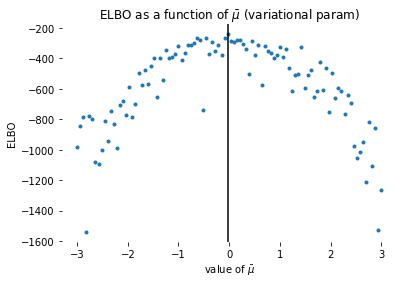

In [169]:
plt.plot(mus, np.array(elbos), '.')
ylim = plt.ylim()
plt.plot([x.mean(), x.mean()], ylim, 'k-')
plt.ylim(ylim)
plt.xlabel('value of $\\bar \\mu$')
plt.ylabel('ELBO')
plt.title('ELBO as a function of $\\bar \\mu$ (variational param)')
plt.box(False)

Our ELBO looks pretty reasonable - it's higher when the value of the variational parameter $\bar \mu$ is close to the empirical mean of the samples (all else being equal). Given this, let's implement the gradient, and then BBVI.

In [174]:
def eval_gradlogQ(z, vparams):
    mu, tau = z
    mu_bar, logsigma_bar, loga_bar, logb_bar = vparams
    sigma_bar = np.exp(logsigma_bar)
    a_bar = np.exp(loga_bar)
    b_bar = np.exp(logb_bar)
    grads = ((1/sigma_bar**2)*(mu-mu_bar),
             -1/sigma_bar**2+1/sigma_bar**3*(mu-mu_bar)**2,
             np.log(b_bar) - scipy.special.digamma(a_bar) + np.log(tau),
             a_bar / b_bar - tau
    )
    return grads

# Check grads
delta = 1E-5
z = (0.1, 1.1)
p0 = [0, 1, 1, 1]
E = eval_logQ(z, tuple(p0))
Es = np.zeros(4,)
for i in range(4):
    p1 = p0.copy()
    p1[i] += delta
    Es[i] = eval_logQ(z, tuple(p1))
    
g_est = (Es - E) / delta
g = eval_gradlogQ(z, tuple(p0))

#assert np.allclose(g, g_est, 1E-4)
print(g)
print(g_est)

(0.013533528323661271, -0.13483741255293405, 0.2903839053407585, -0.10000000000000009)
[ 0.01353285 -0.99864666  0.78933285 -0.27184313]


True mu, empirical mean, estimated mu:
(0, -0.033156178895960974, 0.009668838446801829)
True tau, empiral 1/std, estimated tau:
(1.7103380467262208, 1.7055926498957212, 1.5181585765326189)


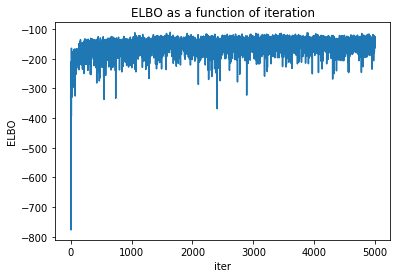

<Figure size 432x288 with 0 Axes>

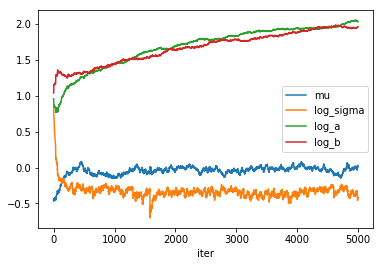

<Figure size 432x288 with 0 Axes>

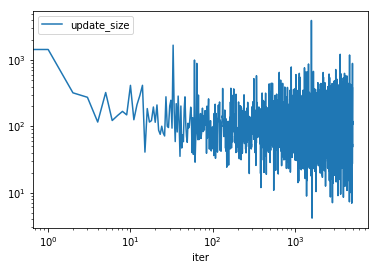

In [251]:
def bbvi(x, vparams, S, max_iter=100, rho=1E-5, elbo_samples=100):
    # Algorithm 1 in https://arxiv.org/pdf/1401.0118.pdf
    iters = []
    for i in range(max_iter):
        g_mean = 0
        for s in range(S):
            z = sample_q(vparams)
            score = np.array(eval_gradlogQ(z, vparams))
            g_estim = score * (np.array(eval_logpxz(x, z)) - np.array(eval_logQ(z, vparams)))
            g_mean += 1/S * g_estim
        
        # Perform gradient descent.
        vparams = tuple(np.array(vparams) + rho*g_mean)
        iters.append({'iter':i,
                      'elbo': elbo(x, vparams, elbo_samples),
                      'update_size': np.sqrt((g_mean**2).sum()),
                      'params': vparams})
    return vparams, iters

x, true_mu, true_tau = get_forward_samples((mu0, gamma0, a0, b0), N_samples)

vparams = (-.5, 1, 1, 1)
vparams_est, iters = bbvi(x, vparams, 25, max_iter=5000, rho=1E-4, elbo_samples=10)
df_iter = pd.DataFrame(iters)
df_iter = df_iter.set_index('iter')

ps = df_iter.params
vals = np.concatenate(ps.values).reshape((-1, len(ps.values[0])))
for i, k in enumerate(('mu', 'log_sigma', 'log_a', 'log_b')):
    df_iter[k] = vals[:, i]

plt.figure()
df_iter.elbo.plot()
plt.ylabel('ELBO')
plt.title('ELBO as a function of iteration')
    
plt.figure()
df_iter[['mu', 'log_sigma', 'log_a', 'log_b']].plot()

plt.figure()
df_iter[['update_size']].plot(logx=True, logy=True)

print("True mu, empirical mean, estimated mu:")
print((true_mu, x.mean(), vparams_est[0]))

print("True tau, empiral 1/std, estimated tau:")
print((true_tau, 1/x.std(), np.exp(-vparams_est[1])))

Looks pretty encouraging:

  * the $\mu$ estimate is close to the true parameter
  * the ELBO is increasing
  * the `update_size` is monotonically decreasing
  
However some of the variational params (log_a and log_b) are moving very slowly, and tau seems to be poorly estimated, perhaps due to this  random walk behaviour. Let's try to improve this via better BBVI variants. 